## Modules and utilities

In [1]:
from utilities import *
import numpy as np
import os
import re
import pandas as pd
from scipy import constants
from scipy import signal
from scipy import interpolate
from scipy import fft
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def getforcefiles(dirpath):
    csv_list = []
    for root, dirs, files in os.walk(dirpath):
        for name in files:
            if name.endswith('txt'):
                filename = os.path.join(root, name)
                csv_list.append(filename)
    return csv_list

def importforces(path):
    df = pd.read_csv(path, sep='\t',header=None, names=colnames)
    df['FX_sum'] = df['FX_9504'] + df['FX_9505']
    df['FY_sum'] = df['FY_9504'] + df['FY_9505']
    df['FZ_sum'] = df['FZ_9504'] + df['FZ_9505']
    df['time']=df.index
    return df

def ezplot(df,which=None,save=False):
    fig, ax=plt.subplots( nrows=1, ncols=1 )
    if 'time' in df:
        df.plot.line(x='time',y='FX_sum', ax=ax, lw=0.5, color='red')
        df.plot.line(x='time',y='FY_sum', ax=ax, lw=0.5, color='green')
        df.plot.line(x='time',y='FZ_sum', ax=ax, lw=0.5, color='blue')
    else:
        df.reset_index().plot.line(x='ATI_time',y='FX_sum', ax=ax, lw=0.5, color='red')
        df.reset_index().plot.line(x='ATI_time',y='FY_sum', ax=ax, lw=0.5, color='green')
        df.reset_index().plot.line(x='ATI_time',y='FZ_sum', ax=ax, lw=0.5, color='blue')
    plt.show()
    if save==True:
        wd=os.path.dirname(which)
        title='plot_'+os.path.basename(which).split(".")[0]
        fig.savefig(fname=wd+'/'+title+'.png')
    plt.close(fig)
    return ax

## Import in vivo log

In [3]:
log_path = '/Users/phil/Desktop/rotoscoping/InVivoLog-apr19.csv'
csv_dir = '/Users/phil/Desktop/rotoscoping/forceplate'
colnames = ['FX_9504','FY_9504','FZ_9504','TX_9504','TY_9504','TZ_9504',
            'FX_9505','FY_9505','FZ_9505','TX_9505','TY_9505','TZ_9505']

log = pd.read_csv(log_path, index_col=0)

## Calculate plate resonant frequency
result: 142-150Hz

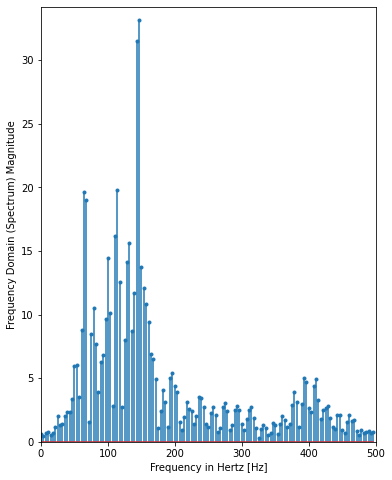

146.42857142857144


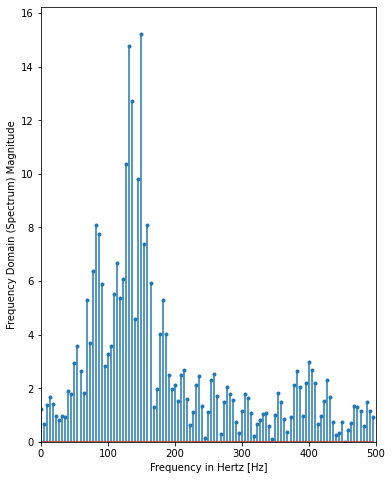

150.0


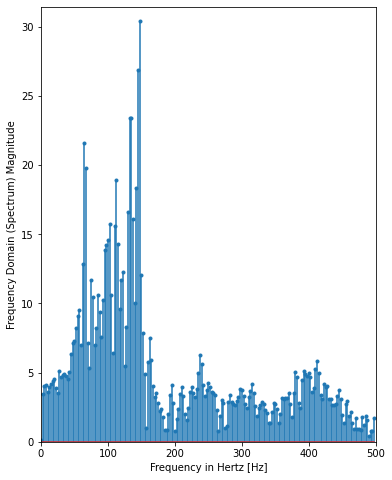

147.5


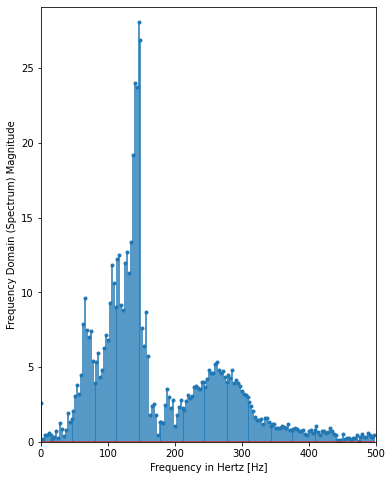

145.71428571428572


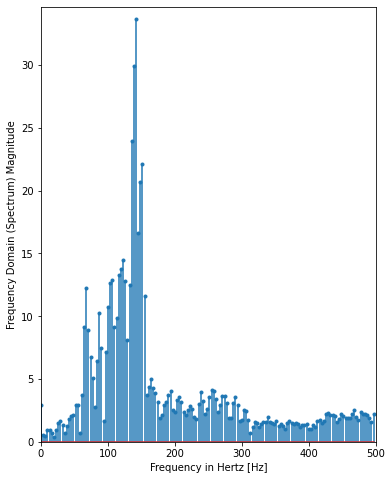

141.93548387096774


In [4]:
sampling_freq = 1000
test_path = '/Users/phil/Desktop/rotoscoping/forceplate/data-sep27-2019/outside_plate_tap_test.txt'
rf_df = importforces(test_path)
tap_one = rf_df.iloc[2120:2400]
tap_two = rf_df.iloc[2780:3000]
tap_three = rf_df.iloc[3400:3800]
tap_four = rf_df.iloc[11250:11600]
tap_five = rf_df.iloc[12190:12500]

def calc_fft(data, sampling_freq):
    X = fft.fft(np.array(data))
    freqs = fft.fftfreq(len(data))*sampling_freq
    fig, ax = plt.subplots(figsize=(6,8))
    ax.stem(freqs, np.abs(X),markerfmt='.')
    ax.set_xlabel('Frequency in Hertz [Hz]')
    ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax.set_xlim(0, sampling_freq /2)
    ax.set_ylim(0, np.abs(X).max()+1)
    plt.show()
    return(freqs[np.abs(X).argmax()])

for tap in [tap_one,tap_two,tap_three,tap_four,tap_five]:
    freq = calc_fft(tap['FZ_sum'],sampling_freq)
    print(freq)

## Grab GRF data

In [5]:
csv_list = getforcefiles(csv_dir)
csv_dict = {
    '21_t2_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/21.txt',
    '20_t3_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/20.txt',
    '12_t1_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/12.txt',
    '23_t3_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/23.txt',
    '9_t4_fullstride_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct7-2019/9.txt',
    '9_p3_fullstride_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct9-2019/9.txt',
    '14_p1_fullstride_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct9-2019/14.txt',
    '3_p2_fullstride_a-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct14-2019/3.txt',
    '8_p4_fullstride_a':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct14-2019/8.txt',
    '9_p2_squeeze_A+':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct16-2019/9.txt',
    '2_t2_squeeze_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-oct23-2019/2.txt',
    '5_t1_squeeze_A+':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov1-2019/5.txt',
    '6_t4_squeeze_A-':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov1-2019/6.txt',
    '3_p4_squeezelow_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov6-2019/3.txt',
    '9_p3_squeezelow_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov6-2019/9.txt',
    '12_p1_squeezelow_A':'/Users/phil/Desktop/rotoscoping/forceplate/data-nov6-2019/12.txt',
    '2_p3_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/2.txt',
    '3_p1_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/3.txt',
    '11_t1_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/11.txt',
    '12_t2_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/12.txt',
    '13_t2_stand':'/Users/phil/Desktop/rotoscoping/forceplate/data-feb3-2020/13.txt',
}
for trial in csv_dict.keys():
    csv_dict[trial] = importforces(csv_dict[trial]).drop(['time'],axis=1)
force_df = pd.concat(csv_dict, names=['Run ID','ATI_time'])

## Find sync peaks

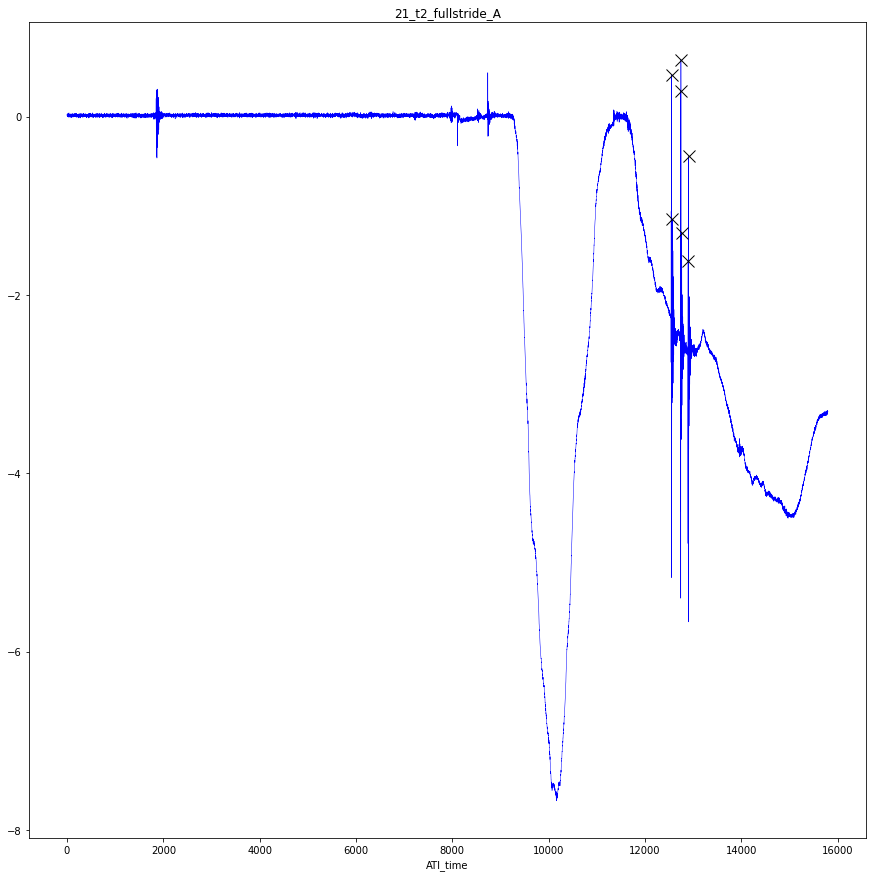

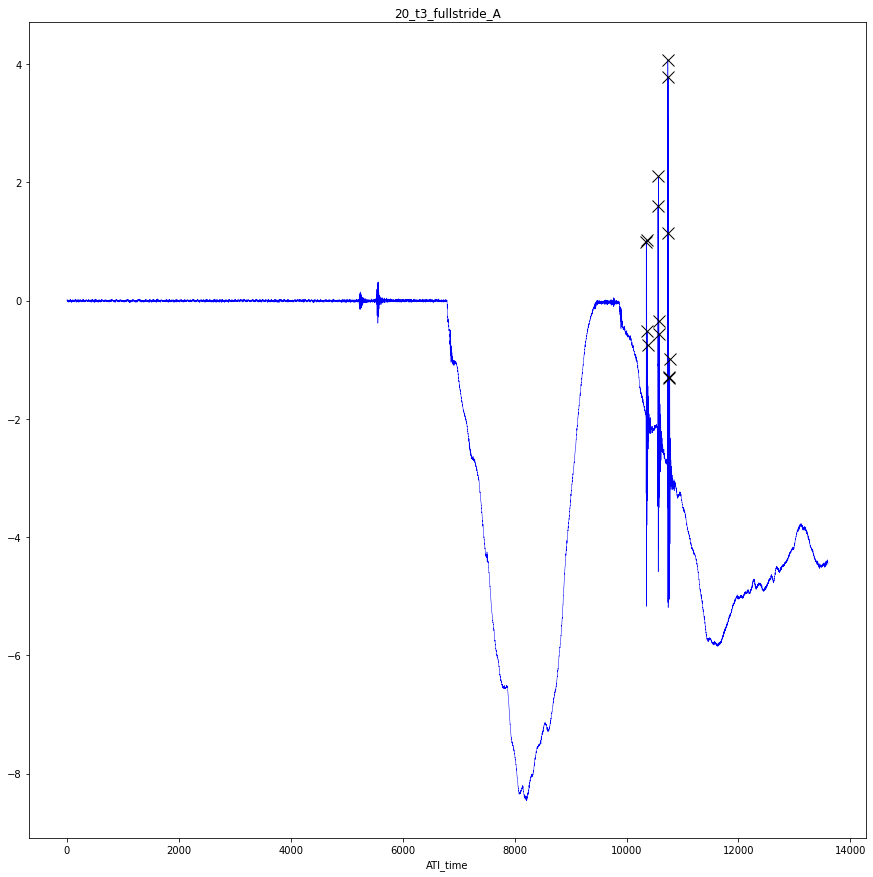

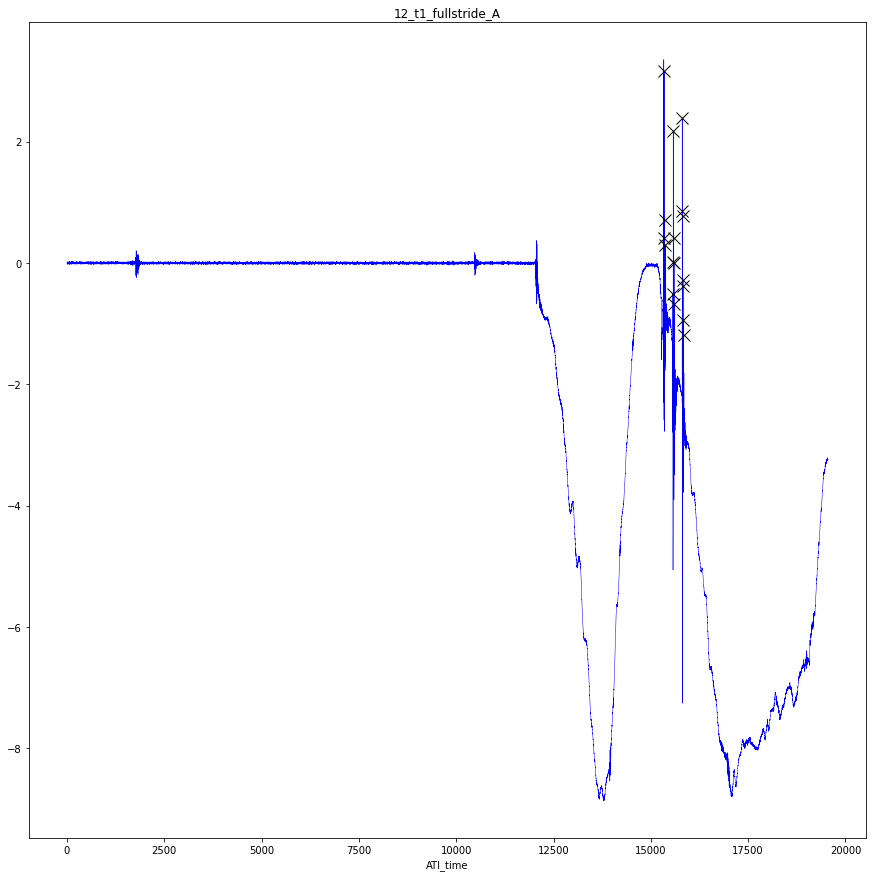

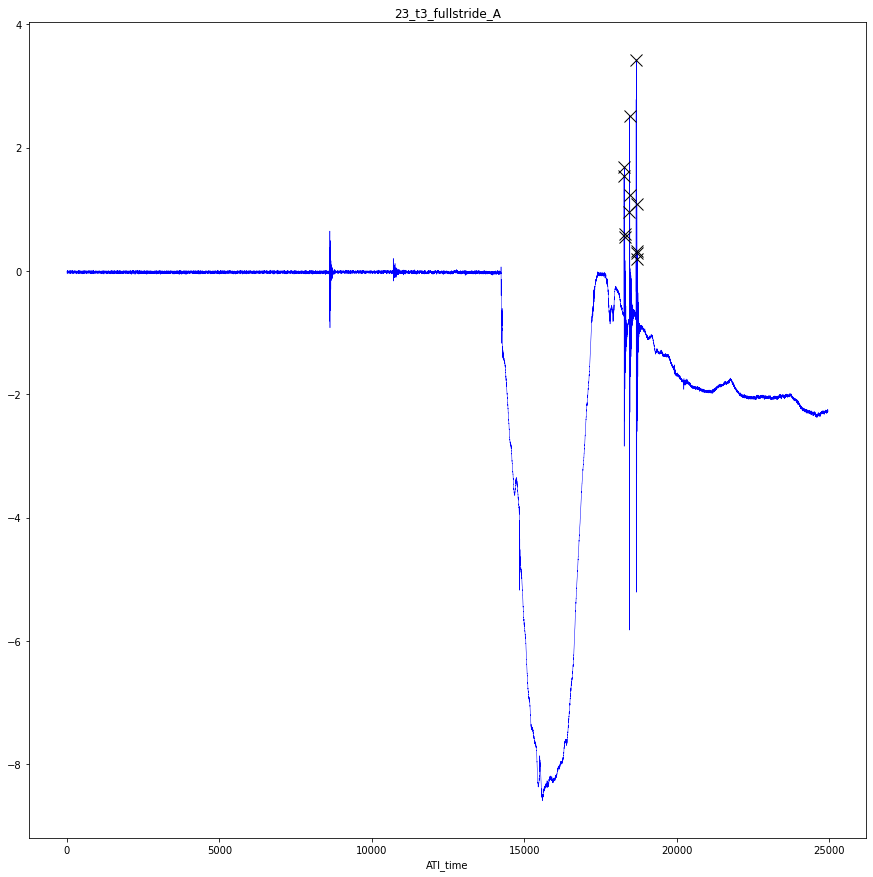

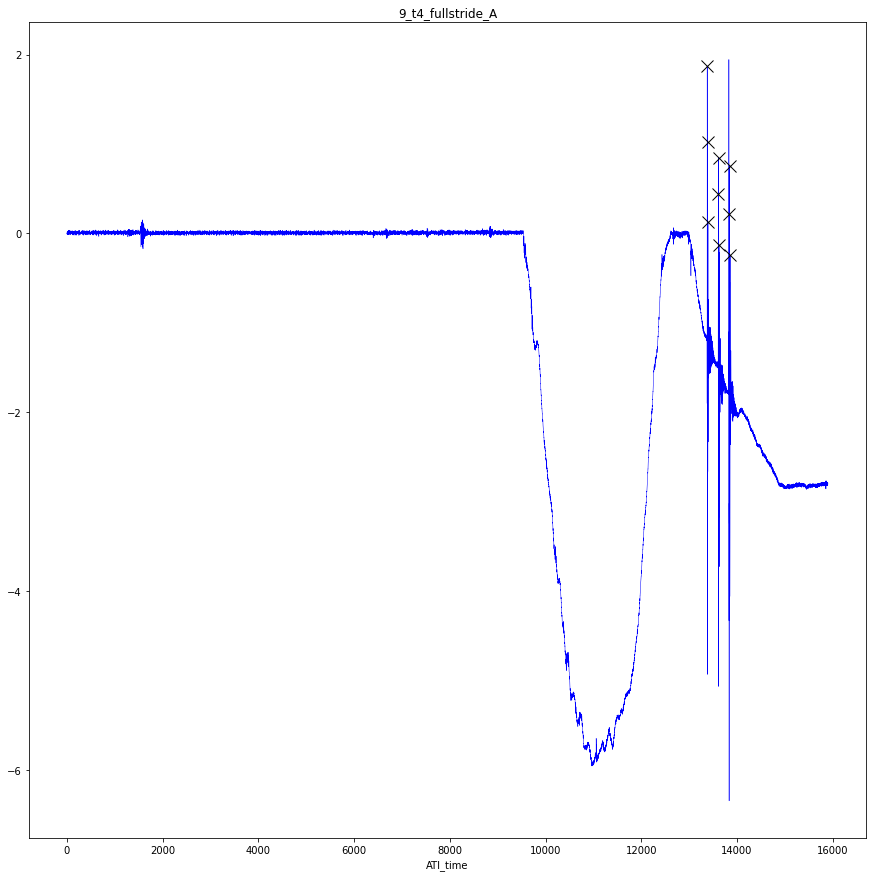

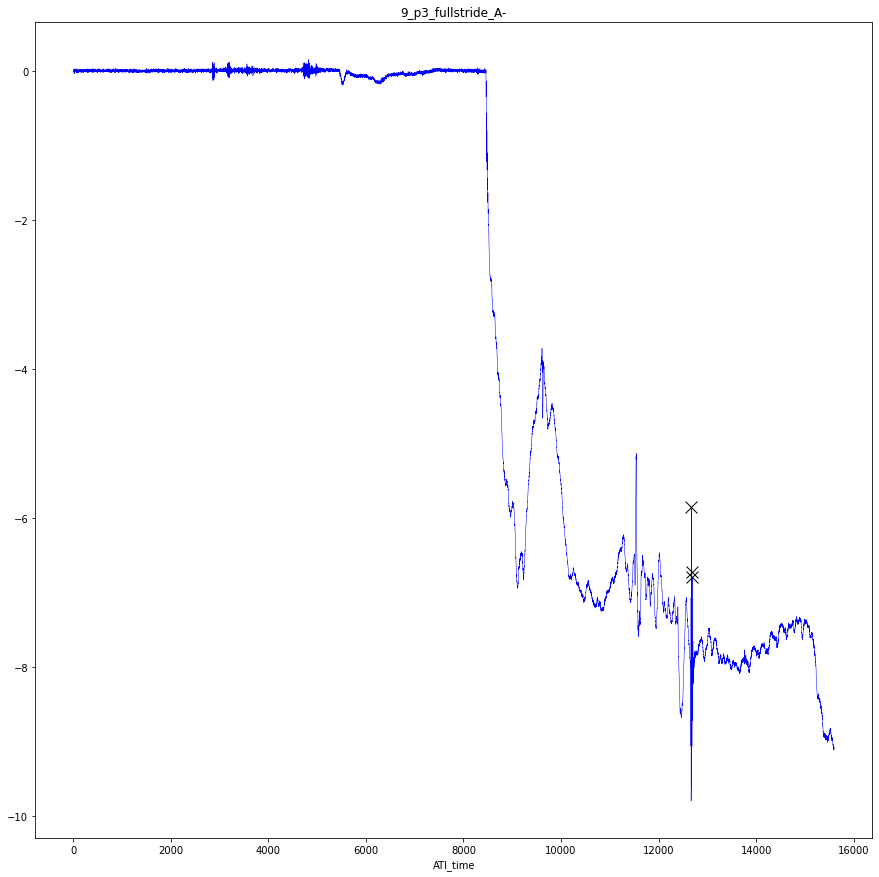

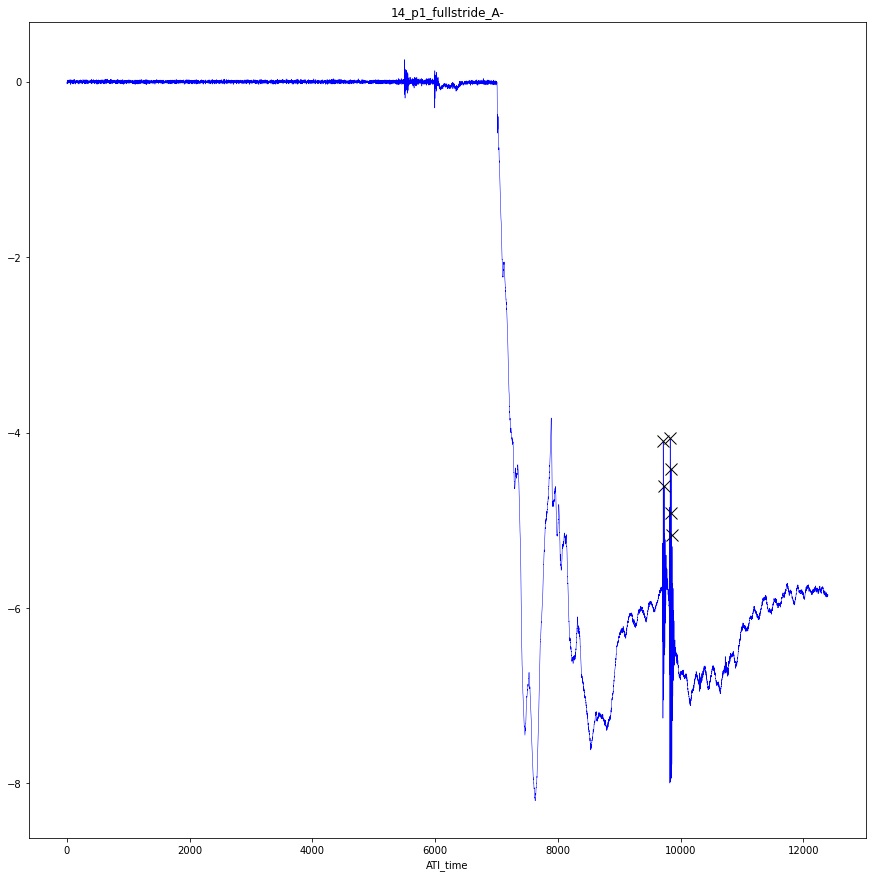

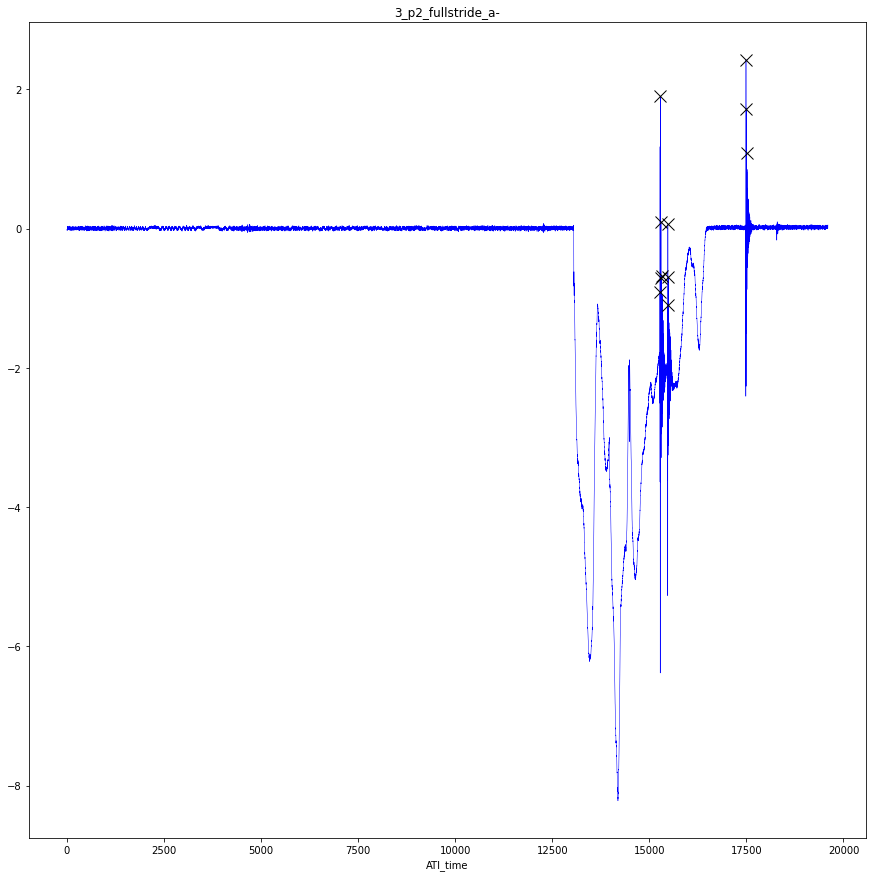

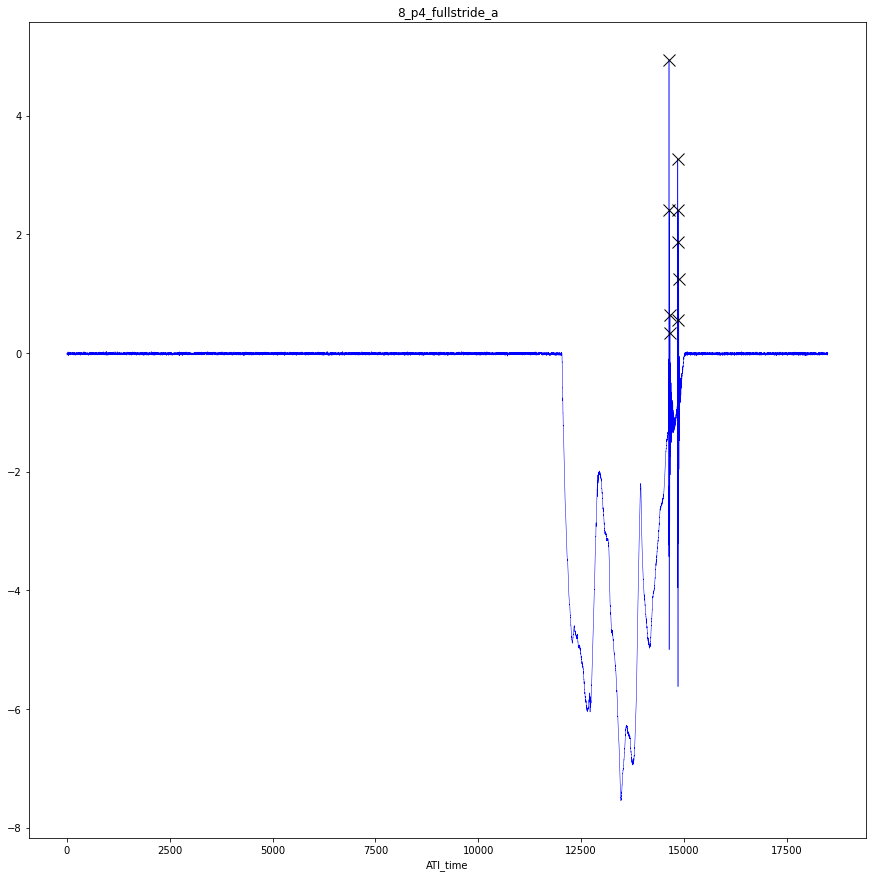

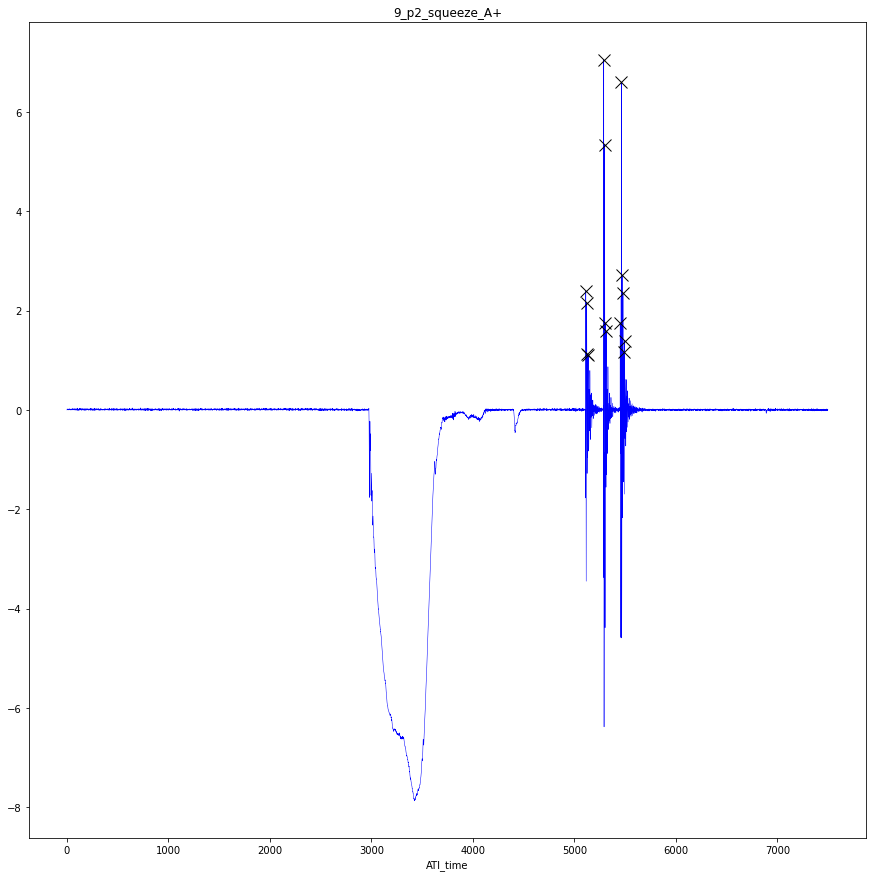

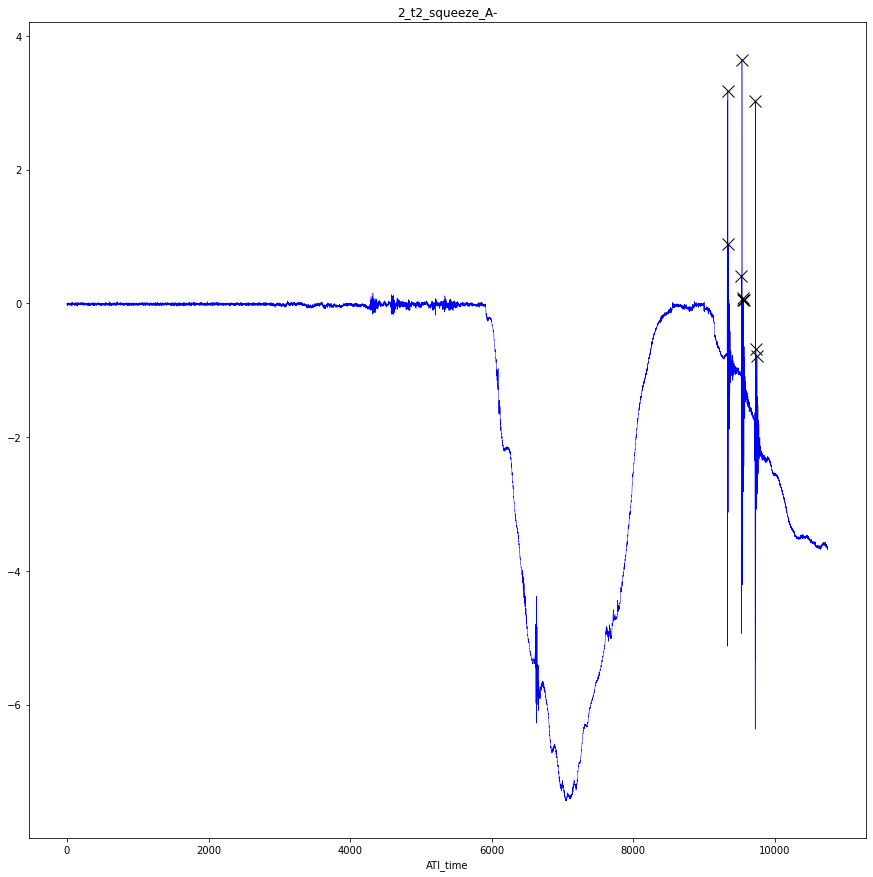

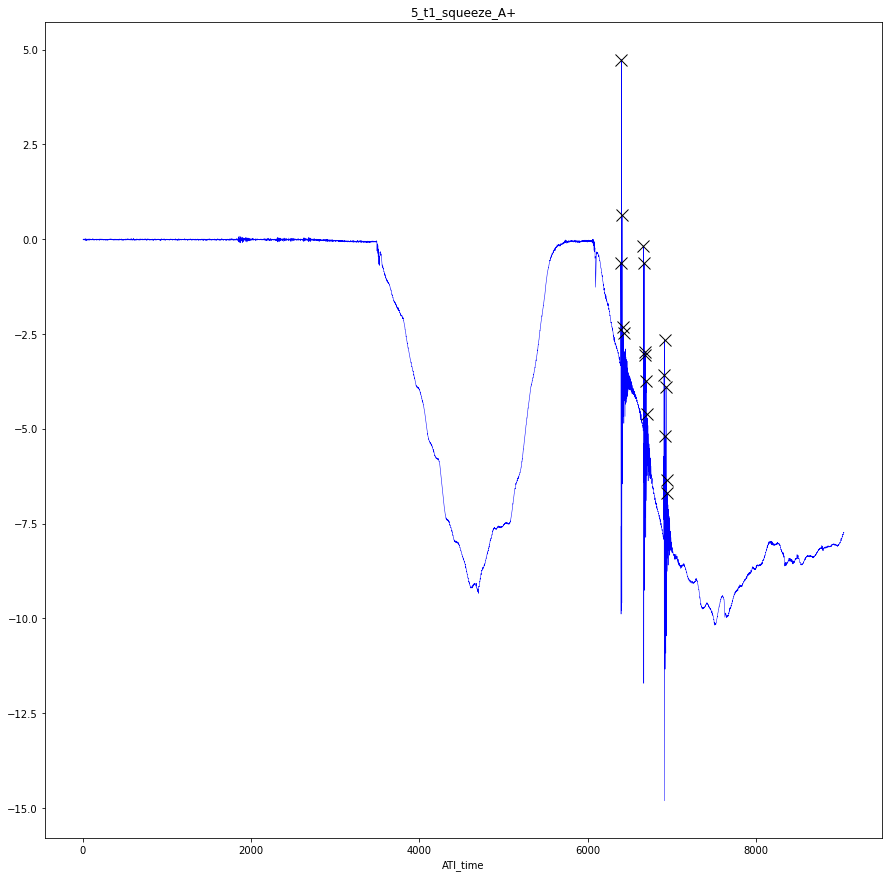

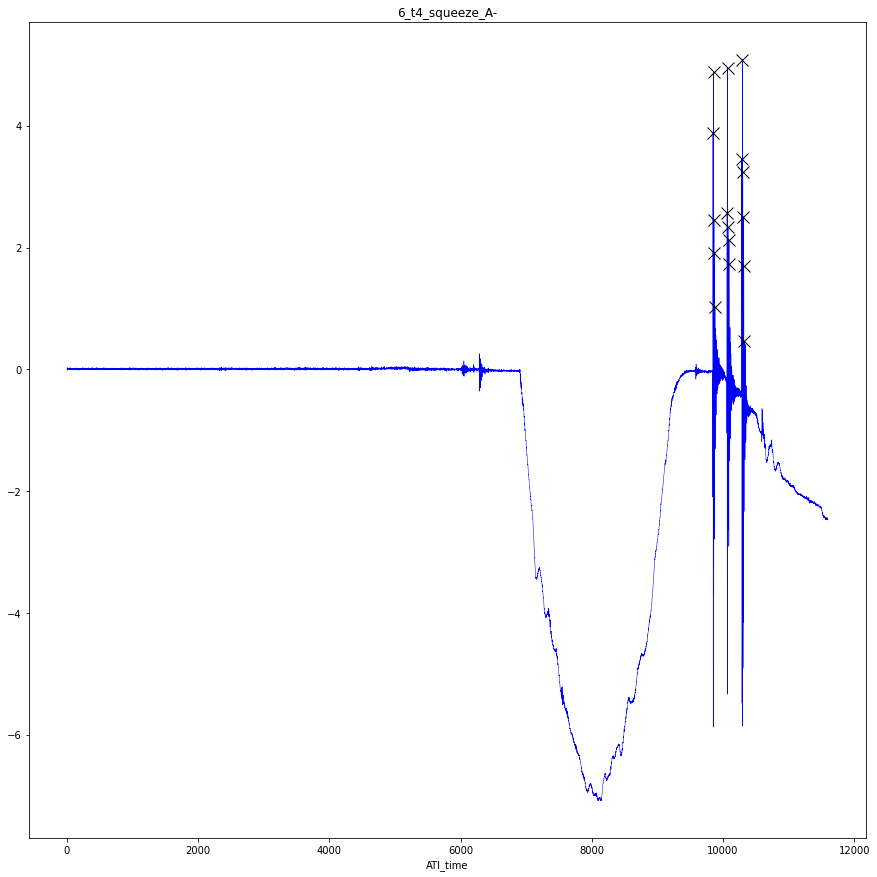

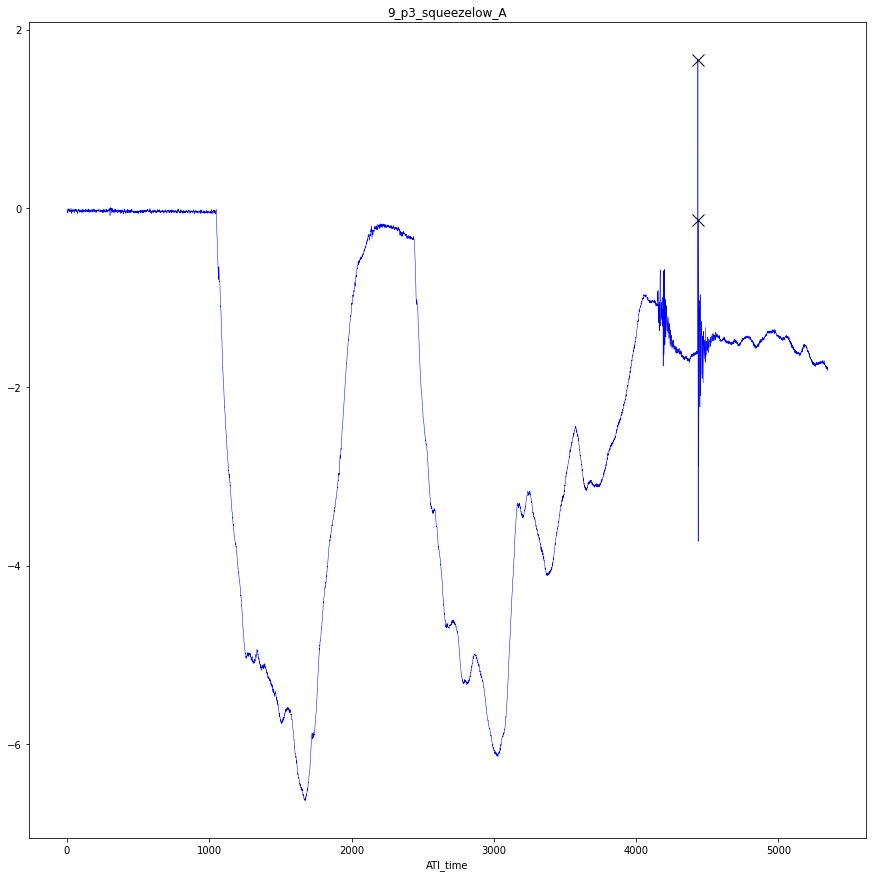

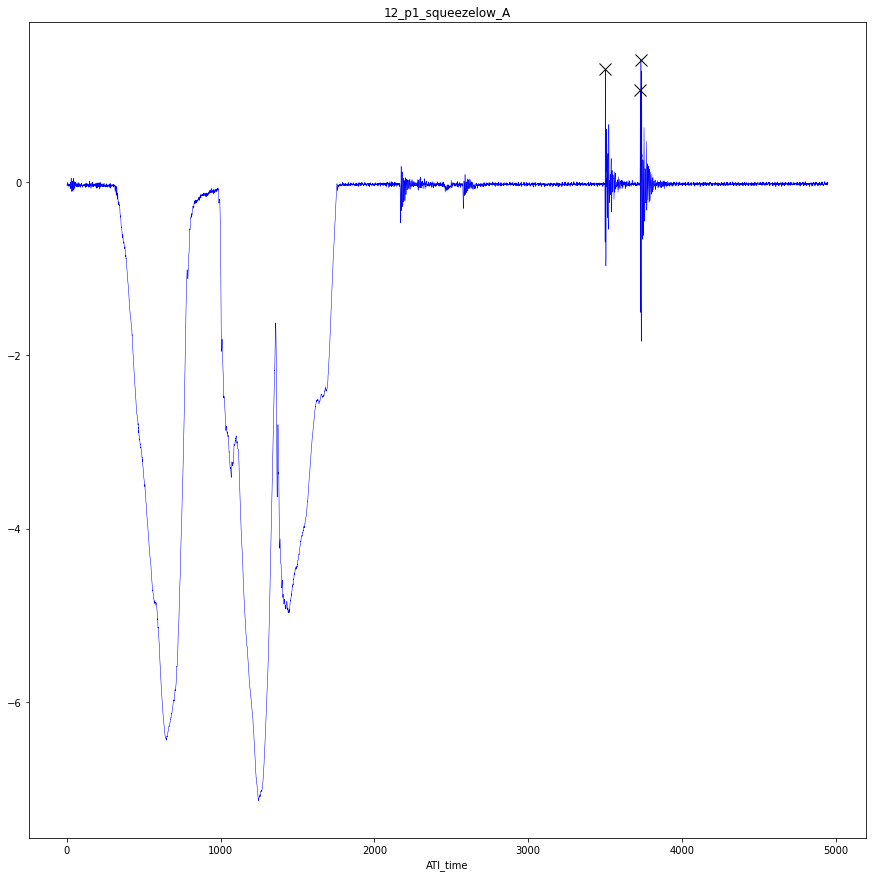

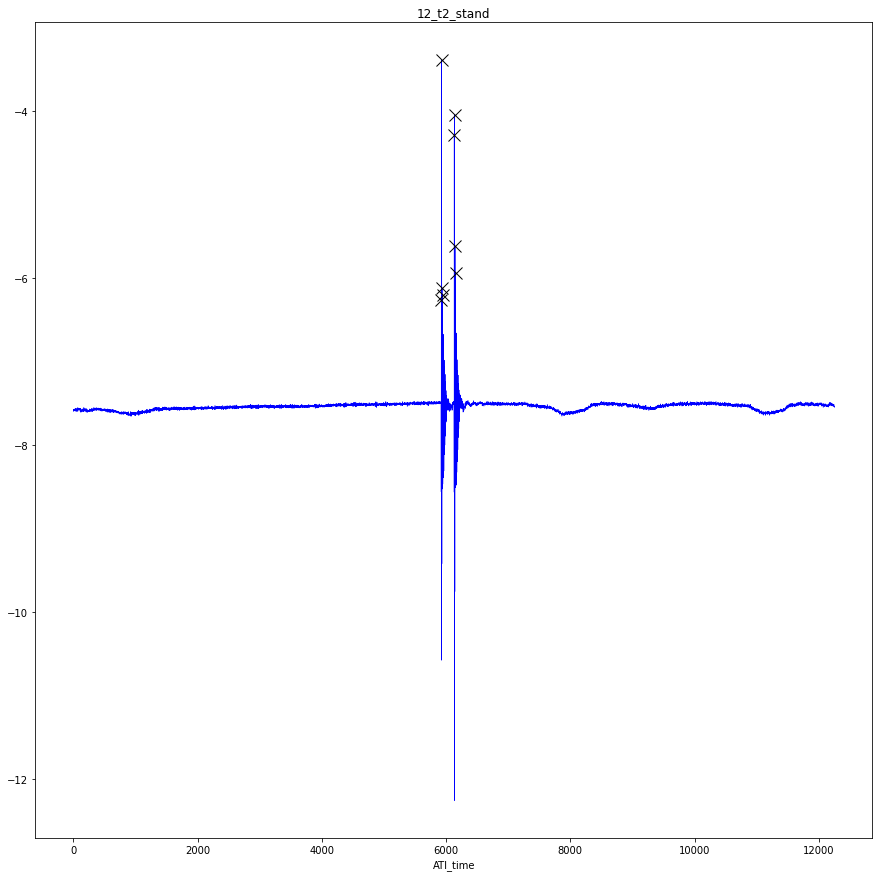

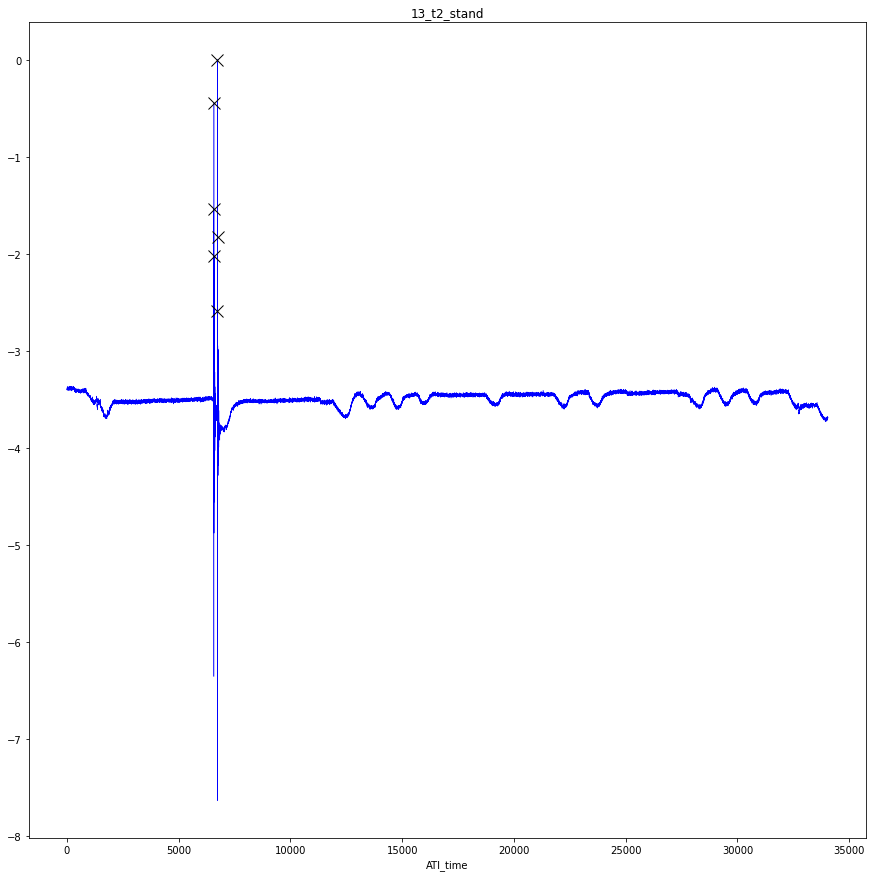

In [6]:
skip_crop = ['3_p4_squeezelow_A', '2_p3_stand','3_p1_stand', '11_t1_stand']
for trial_id in csv_dict.keys():
    if not trial_id in skip_crop:
        zData = force_df.loc[trial_id,'FZ_sum']
        peaks, _ = signal.find_peaks(zData, prominence=2, distance=1, width=(1,10))
        log.loc[trial_id,'force_sync'] = peaks[0]
        fig, ax=plt.subplots( figsize=(15,15) )
        zData.plot.line(x='time',y='FZ_sum', ax=ax, lw=0.5, color='blue')
        ax.plot(peaks, zData[peaks],"x", markersize=12, color="black")
        ax.set_title(trial_id)
        plt.show()

## Normalize by BW

In [7]:
norm_force_df = force_df.copy()
for trial in csv_dict.keys():
    norm_force_df.loc[pd.IndexSlice[trial,:],:]/=(log.loc[trial,'Mass (kg)']*constants.g)

## low-pass butterworth filter

#### choose filter cutoff

#### apply filter

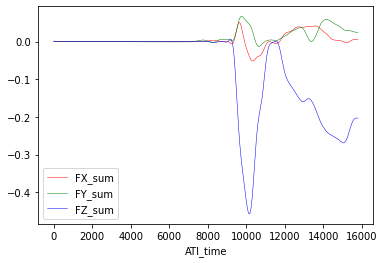

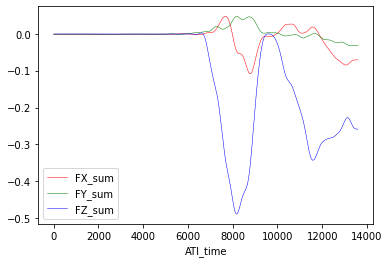

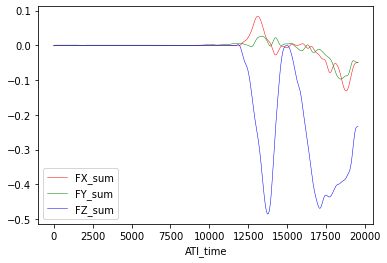

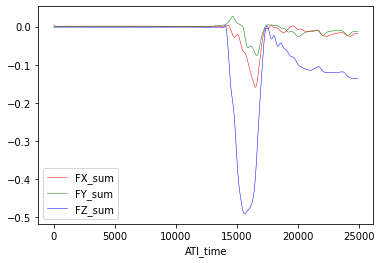

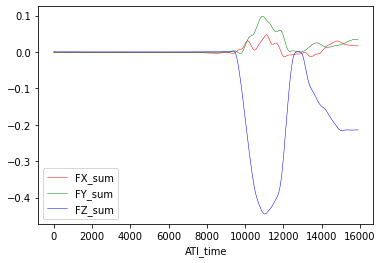

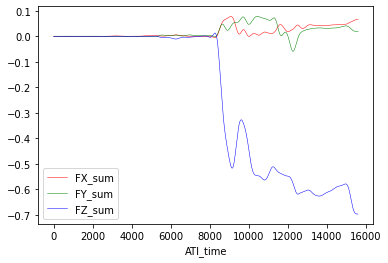

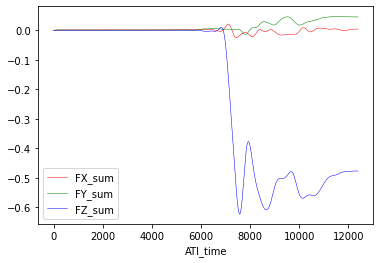

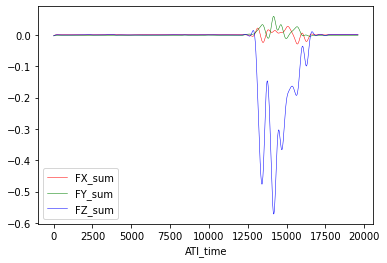

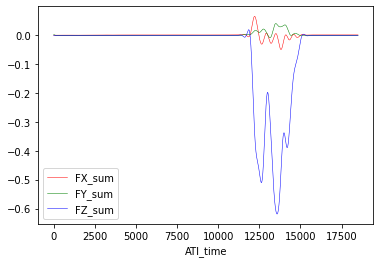

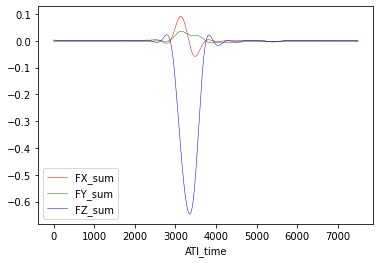

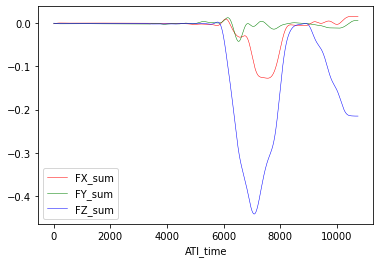

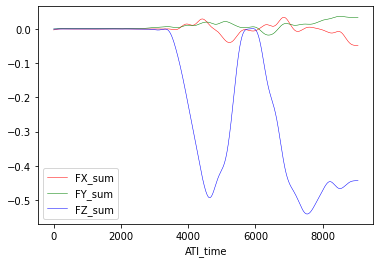

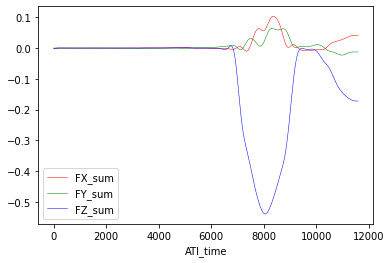

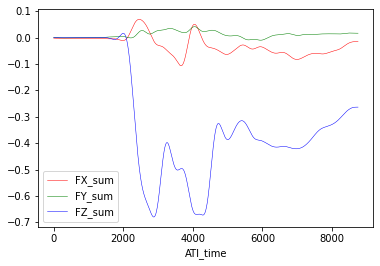

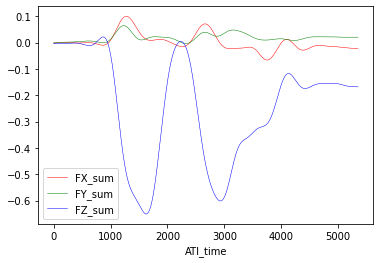

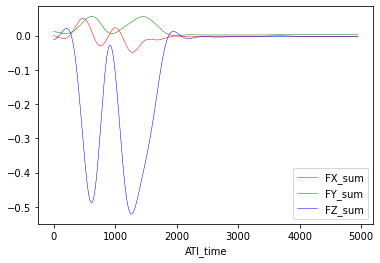

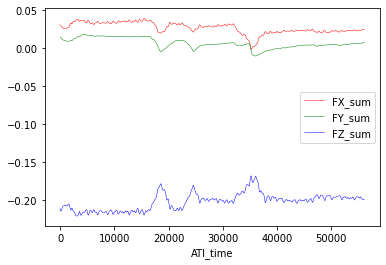

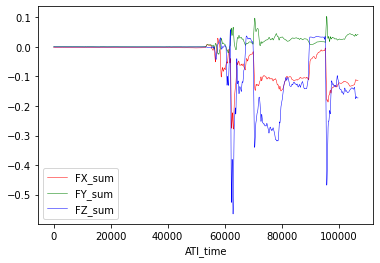

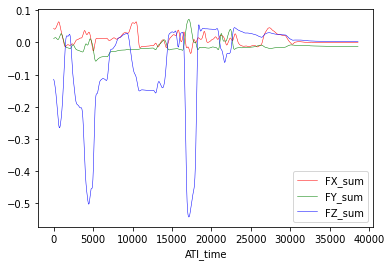

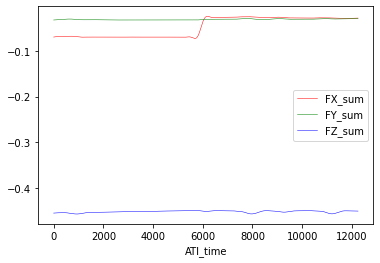

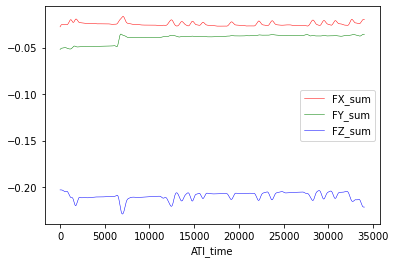

In [137]:
opt_cutoff = 2.1
filt_norm_force_df = norm_force_df.copy()
for trial_id in csv_dict.keys():
    sampling_f = log.loc[trial_id,'ATI sampling (Hz)']
    filt_norm_force_df.loc[trial_id,'FX_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FX_sum'], opt_cutoff, sampling_f)
    filt_norm_force_df.loc[trial_id,'FY_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FY_sum'], opt_cutoff, sampling_f)
    filt_norm_force_df.loc[trial_id,'FZ_sum'] = make_butter(filt_norm_force_df.loc[trial_id,'FZ_sum'], opt_cutoff, sampling_f)
    ezplot(filt_norm_force_df.loc[trial_id])

In [740]:
# deprecated...quintic spline interpolation following gosnell
# forces_interp = forces_bwNorm.copy()
# smoothing_param = 20
# splX = interpolate.UnivariateSpline(forces_interp['time'], forces_interp['FX_sum'], k=5, s=smoothing_param)
# splY = interpolate.UnivariateSpline(forces_interp['time'], forces_interp['FY_sum'], k=5, s=smoothing_param)
# splZ = interpolate.UnivariateSpline(forces_interp['time'], forces_interp['FZ_sum'], k=5, s=smoothing_param)
# xs = np.linspace(0, len(forces_interp), len(forces_interp))

# forces_interp['FX_sum'] = splX(xs)
# forces_interp['FY_sum'] = splY(xs)
# forces_interp['FZ_sum'] = splZ(xs)

## Crop force data to first tap

In [141]:
cropped_force_df = filt_norm_force_df.copy()
for trial_id in csv_dict.keys():
    sync_time = log.loc[trial_id,'force_sync']
    if not np.isnan(sync_time):
        sync_time_int = math.floor(sync_time)
        cropped_force_df.drop(cropped_force_df.loc[(trial_id,sync_time_int):(trial_id,)].index, inplace=True)

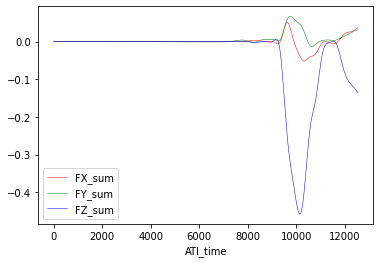

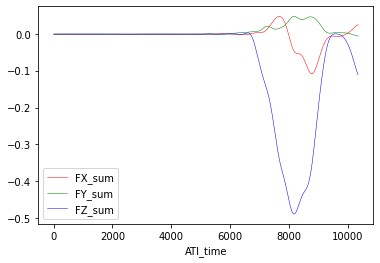

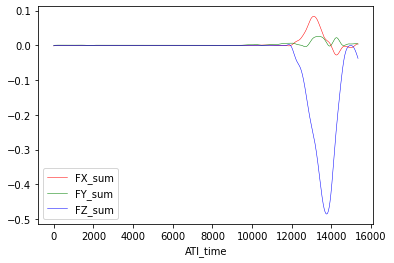

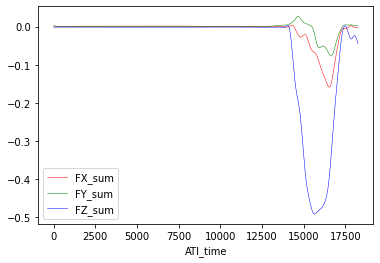

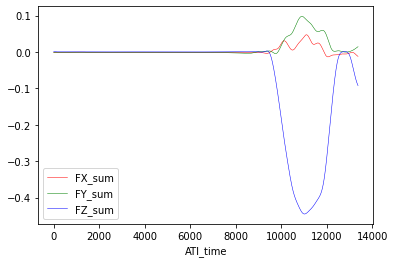

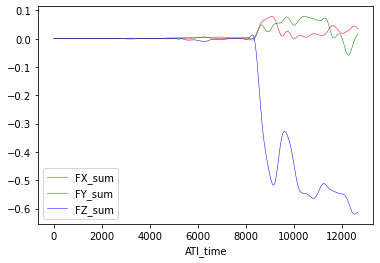

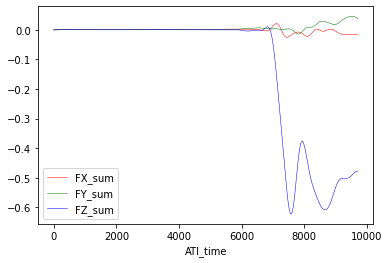

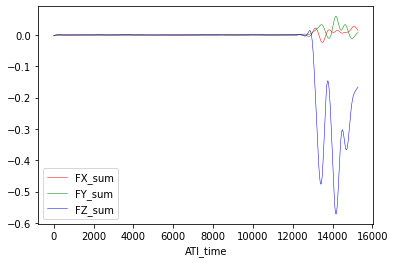

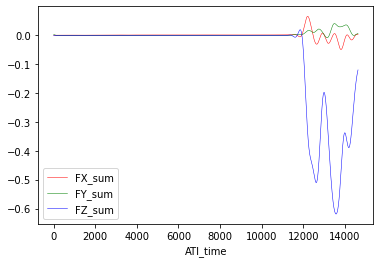

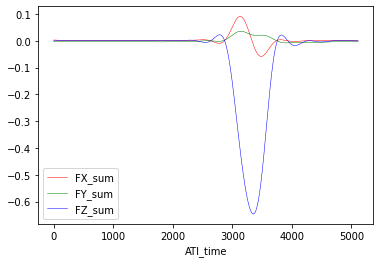

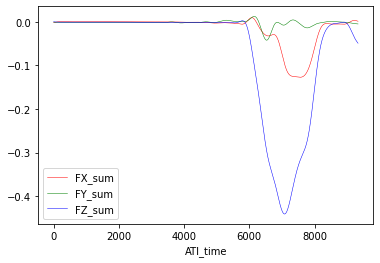

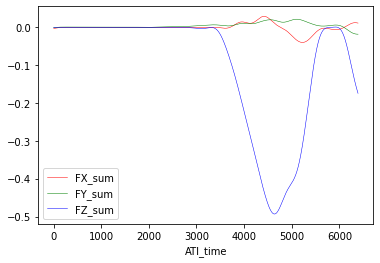

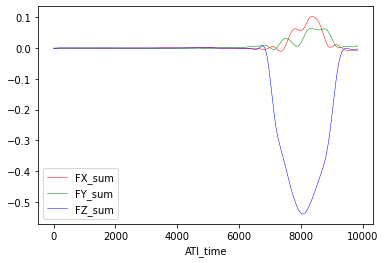

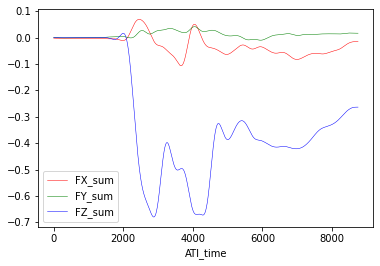

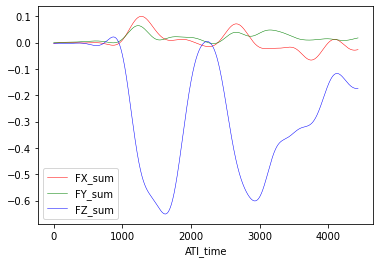

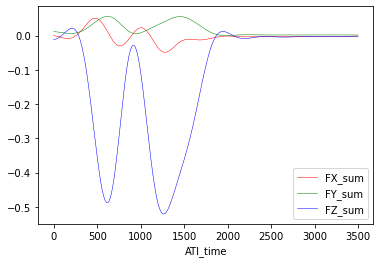

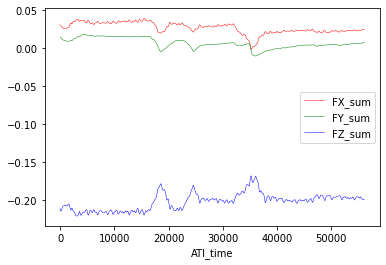

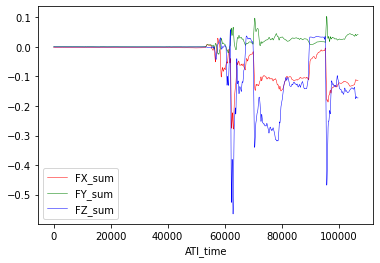

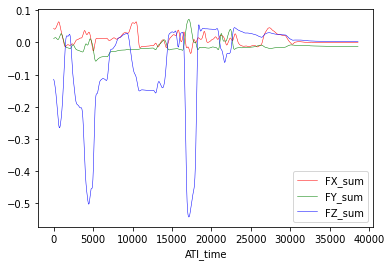

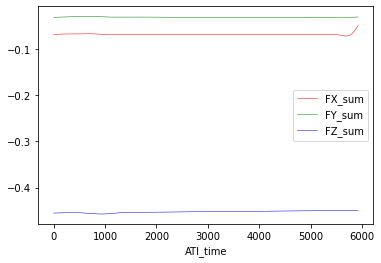

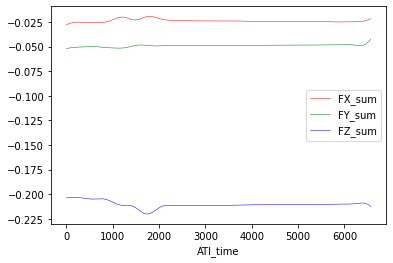

In [142]:
for trial_id in csv_dict.keys():
    ezplot(cropped_force_df.loc[trial_id])

## Resample to XROMM framerate

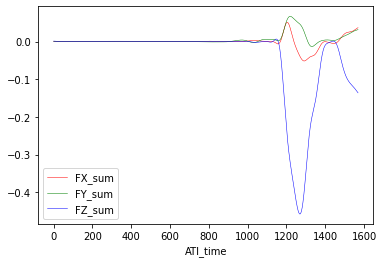

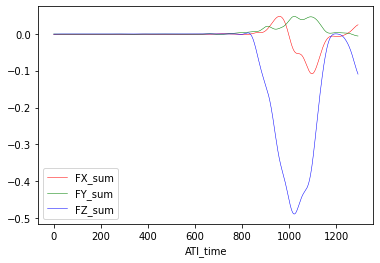

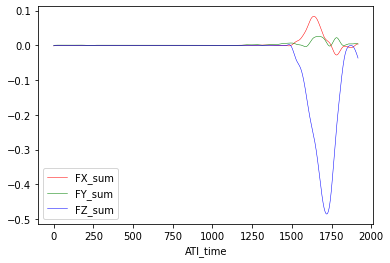

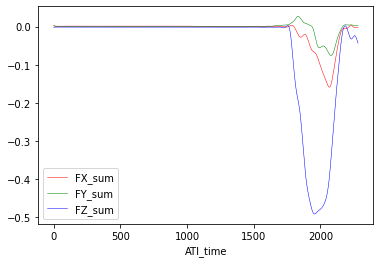

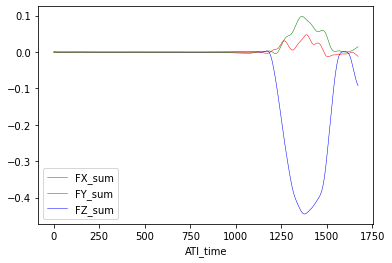

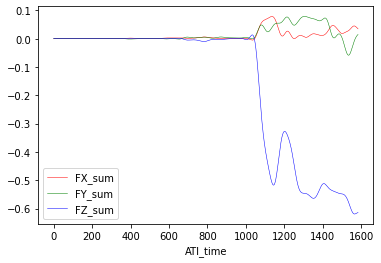

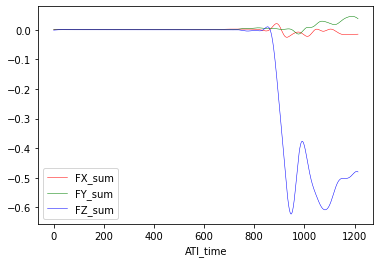

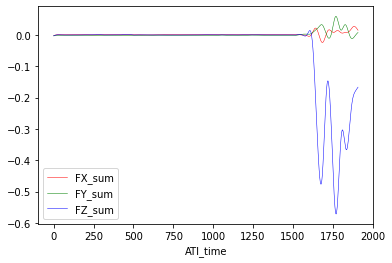

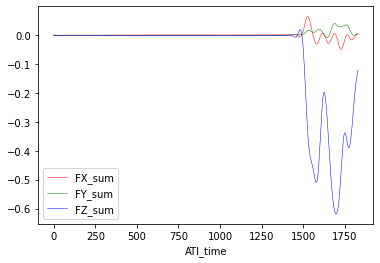

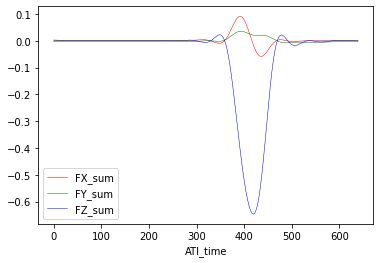

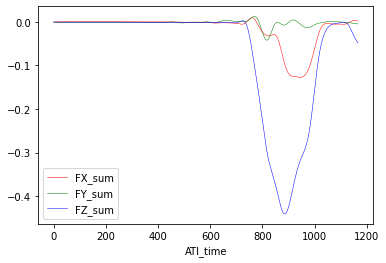

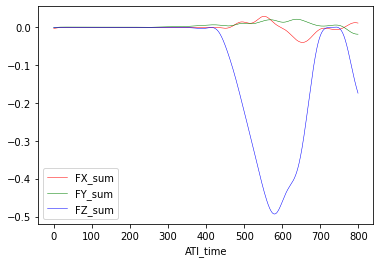

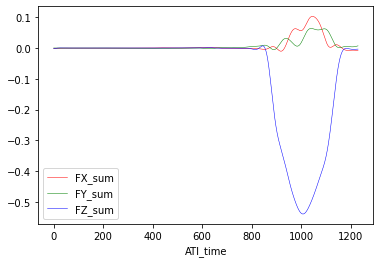

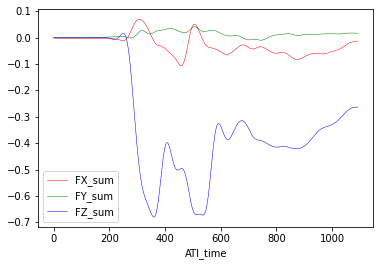

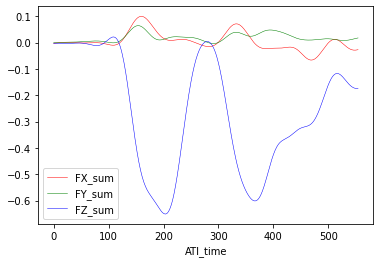

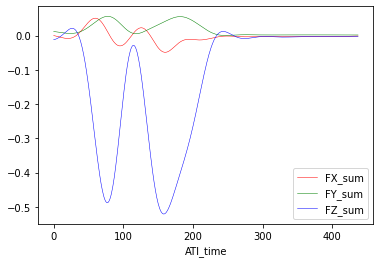

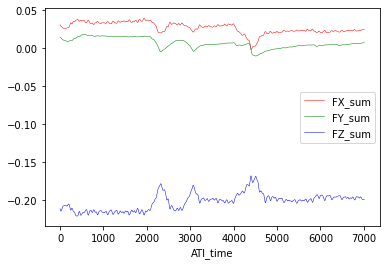

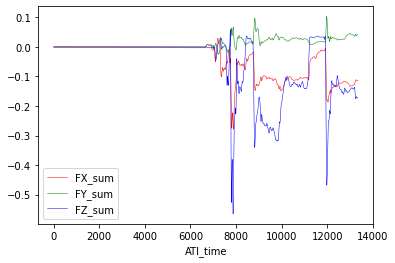

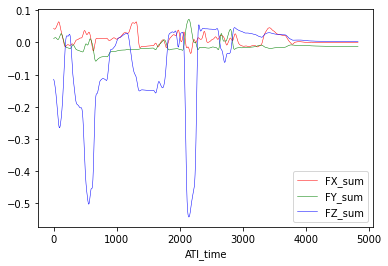

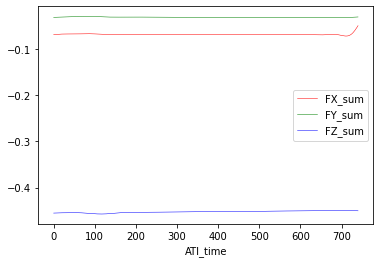

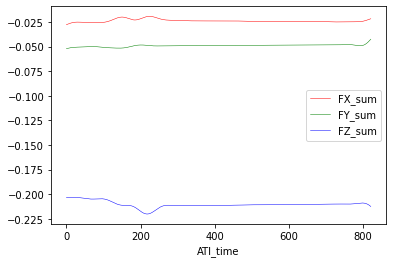

In [144]:
resampled_force_df = cropped_force_df.copy()
sort_order = list(csv_dict.keys())
resampled_force_df.index = resampled_force_df.index.set_levels(pd.to_timedelta(resampled_force_df.index.levels[1], unit='ms'), level=1)
resampled_force_df = resampled_force_df.groupby(level=0).apply(lambda x: x.reset_index(level=0,drop=True).resample(rule='8L').asfreq())
resampled_force_df.index = resampled_force_df.index.set_levels(pd.to_numeric(resampled_force_df.index.levels[1]), level=1)
resampled_force_df.index = resampled_force_df.index.set_levels(resampled_force_df.index.levels[1]/8000000, level=1)
resampled_force_df.index = resampled_force_df.index.set_levels(pd.to_numeric(resampled_force_df.index.levels[1],downcast='integer'), level=1)
resampled_force_df.reindex(sort_order, level=0)
for trial_id in csv_dict.keys():
    ezplot(resampled_force_df.loc[trial_id])

## Save out processed force data

In [145]:
out_dir = '/Users/phil/Desktop/rotoscoping/processed-forces-apr21'
export_force_df = resampled_force_df.loc[:,['FX_sum','FY_sum','FZ_sum']]
export_force_df.loc[:,['FX_sum','FZ_sum']] *= -1 #xromm scenes are LR flipped, reverse polarity of Z and X to get reaction force but leave ML (Y) as is
export_force_df.index.set_names(['trial','frame'], inplace=True)
export_force_df.columns = ['FX','FY','FZ']
for trial_id in csv_dict.keys():
    out_path = os.path.join(out_dir,trial_id+'.csv')
    ex_df = export_force_df.loc[trial_id]
    ex_df.to_csv(out_path)